In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:
import nltk
import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...


# Model 1 - With Lemmatizaton

In [18]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# === Clean the text with lemmatization ===
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = ''.join([char for char in text if char not in string.punctuation])
        words = [word for word in text.split() if word not in stop_words]
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)
    return ""

df = pd.read_csv("/kaggle/input/news-dataset/dataset.csv")

df['cleaned_title'] = df['title'].apply(clean_text)
df['cleaned_text'] = df['text'].apply(clean_text)
df['combined_text'] = df['cleaned_title'] + ' ' + df['cleaned_text']

df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

df.dropna(subset=['sentiment', 'combined_text'], inplace=True)

X = df['combined_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === TF-IDF Vectorization ===
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()




Epoch 1/20
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7791 - loss: 0.5928 - val_accuracy: 0.8395 - val_loss: 0.5105
Epoch 2/20
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8435 - loss: 0.5072 - val_accuracy: 0.8478 - val_loss: 0.4905
Epoch 3/20
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8526 - loss: 0.4862 - val_accuracy: 0.8535 - val_loss: 0.4743
Epoch 4/20
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8544 - loss: 0.4771 - val_accuracy: 0.8501 - val_loss: 0.4799
Epoch 5/20
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8605 - loss: 0.4656 - val_accuracy: 0.8582 - val_loss: 0.4710
Epoch 6/20
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8644 - loss: 0.4626 - val_accuracy: 0.8540 - val_loss: 0.4707
Epoch 7/20
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8677 - loss: 0.4545 - val_accuracy: 0.8598 - val_loss: 0.4680
Epoch 8/20
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8704 - loss: 0.4499 - 

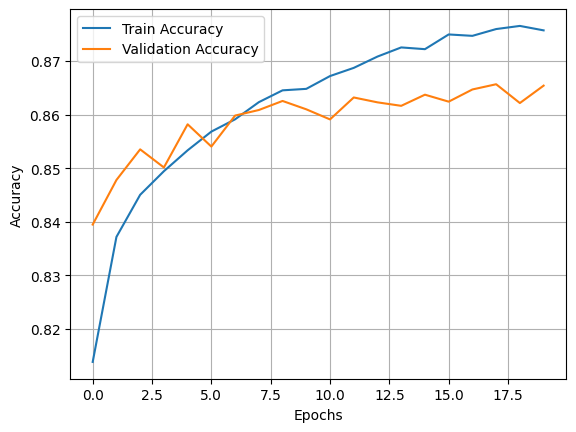

In [20]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
model = Sequential([
    Input(shape=(X_train_tfidf.shape[1],)),  # ✅ cleaner input layer
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # ✅ for binary classification
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# === Train the Model ===
history = model.fit(X_train_tfidf, y_train, epochs=20, batch_size=32, validation_data=(X_test_tfidf, y_test))

# === Evaluate ===
loss, accuracy = model.evaluate(X_test_tfidf, y_test)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# === Plot Accuracy ===
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# === SAVE TRAINED MODEL AND TF-IDF VECTORIZER ===
model.save("sentiment_model.h5")
print("✅ Model saved as 'sentiment_model.h5'")

import pickle
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
print("✅ TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'")


✅ Model saved as 'sentiment_model.h5'
✅ TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'


In [22]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Model-2

In [ ]:
# === [1] Imports and Downloads ===
import numpy as np
import pandas as pd
import string
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split



from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# === [2] POS-Aware Lemmatization ===
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = ''.join([char for char in text if char not in string.punctuation])
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in stop_words]
        tagged = pos_tag(tokens)
        lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged]
        return ' '.join(lemmatized)
    return ""

# === [3] Load and Clean Dataset ===
df = pd.read_csv("/kaggle/input/news-dataset/dataset.csv")
df = df[df['sentiment'].isin(['positive', 'negative'])]  # only binary

df['cleaned_title'] = df['title'].apply(clean_text)
df['cleaned_text'] = df['text'].apply(clean_text)
df['combined_text'] = df['cleaned_title'] + ' ' + df['cleaned_text']

df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.dropna(subset=['sentiment', 'combined_text'], inplace=True)

X = df['combined_text']
y = df['sentiment']

# === [4] Split Data ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === [5] Tokenize and Pad ===
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 1000
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential

# === [6] Build LSTM Model with Bidirectional ===
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),  # 🔁 Bidirectional layer
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === [7] Callbacks to Prevent Overfitting ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# === [8] Train with Callbacks ===
history = model.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/15
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7762 - loss: 0.4517 - val_accuracy: 0.8683 - val_loss: 0.3050 - learning_rate: 0.0010
Epoch 2/15
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9034 - loss: 0.2426 - val_accuracy: 0.8753 - val_loss: 0.2934 - learning_rate: 0.0010
Epoch 3/15
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9387 - loss: 0.1604 - val_accuracy: 0.8683 - val_loss: 0.3403 - learning_rate: 0.0010
Epoch 4/15
1921/1925 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9656 - loss: 0.0965
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9656 - loss: 0.0965 - val_accuracy: 0.8653 - val_loss: 0.4040 - learning_rate: 0.0010
Epoch 5/15
1925/1925 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9850 - loss: 0.0467 - val_accuracy: 0.8651 - val_loss: 0.6064 - learning_rate: 5.0000e-04


482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8737 - loss: 0.2979

✅ Test Accuracy: 87.53%


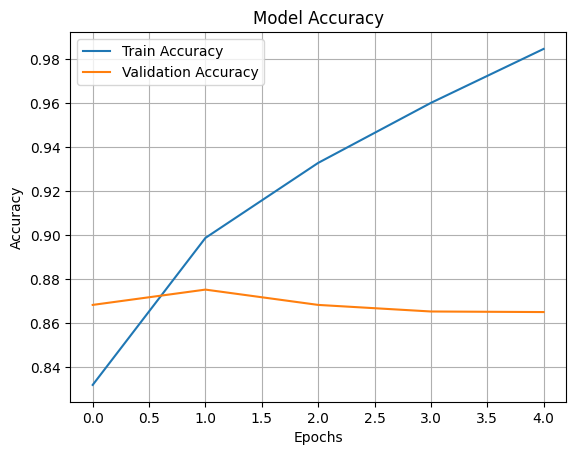

In [27]:
# === [8] Evaluate ===
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

# === [9] Plot Accuracy ===
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Model Accuracy')
plt.show()

In [29]:
import pickle

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Load tokenizer on other machine
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
